In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
# import all from /raw_data/
all_acc_csvs = glob.glob(os.getcwd() + "/raw_data/accelerometer/*.csv")
all_gyro_csvs = glob.glob(os.getcwd() + "/raw_data/gyroscope/*.csv")

sensor_df = pd.DataFrame()
for acc_file, gyro_file in zip(all_acc_csvs, all_gyro_csvs):
    acc_df = pd.read_csv(acc_file).loc[:, ["Timestamp", "x", "y", "z", "payload"]] \
        .rename(columns={"x": "acc_x", "y": "acc_y", "z": "acc_z"})

    gyro_df = pd.read_csv(gyro_file).loc[:, ["Timestamp", "x", "y", "z", "payload"]] \
        .rename(columns={"x": "gyro_x", "y": "gyro_y", "z": "gyro_z"})

    combined_df = pd.merge_asof(acc_df.sort_values("Timestamp"), gyro_df.sort_values("Timestamp"), on="Timestamp", direction="nearest") \
        .loc[:, ["Timestamp", "acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z", "payload_x"]] \
            .rename(columns={"payload_x": "payload"})

    sensor_df = pd.concat([sensor_df, combined_df], axis=0)

print(sensor_df.head())

       Timestamp     acc_x     acc_y     acc_z    gyro_x    gyro_y    gyro_z  \
0  1636227071563  0.172474 -0.106599  9.778942  0.000666  0.002131  0.001731   
1  1636227071574  0.206610 -0.097017  9.807089  0.000666  0.002131  0.001731   
2  1636227071586  0.143729 -0.082644  9.754988  0.000666  0.002131  0.001731   
3  1636227071599  0.158102 -0.111390  9.825654  0.000666  0.002131  0.001731   
4  1636227071616  0.158102 -0.178463  9.759778  0.000666  0.002131  0.001731   

  payload  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  


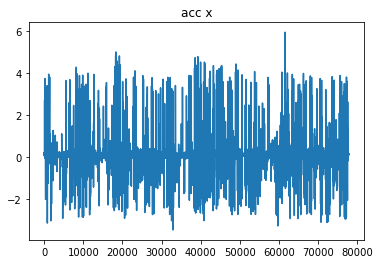

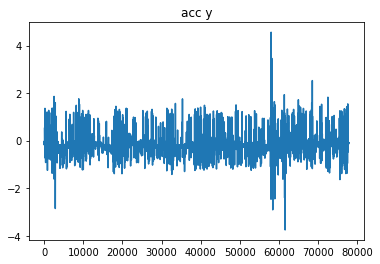

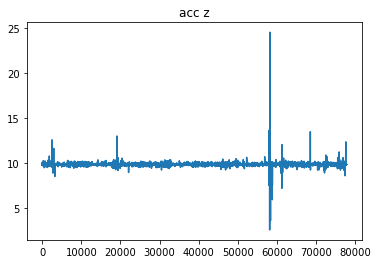

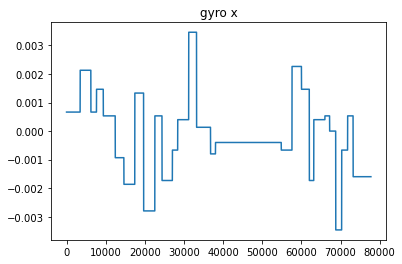

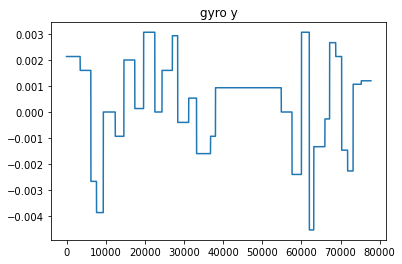

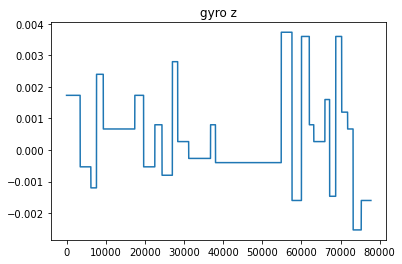

In [3]:
for sensor in ["acc", "gyro"]:
    plt.plot(range(len(sensor_df)), sensor_df[sensor + "_x"])
    plt.title(sensor + " x")
    plt.show()
    plt.plot(range(len(sensor_df)), sensor_df[sensor + "_y"])
    plt.title(sensor + " y")
    plt.show()
    plt.plot(range(len(sensor_df)), sensor_df[sensor + "_z"])
    plt.title(sensor + " z")
    plt.show()

In [4]:
current_payload = None
payload_change_indices = []
y_final_payload = []
print("Payload: ")
for index, reading in enumerate(sensor_df.values):
    if str(reading[7]) != "nan" and reading[7] != current_payload:
        current_payload = reading[7]
        added_symbol = str(current_payload[-1])

        payload_change_indices.append(index)
        y_final_payload.append(added_symbol)
        print(added_symbol, end='')

print("\n", "# of readings:", len(sensor_df.values))
print(" # of payload changes:", len(payload_change_indices))
print(" Payload change indices:", payload_change_indices)

Payload: 
This is a test ofcf changes in data with no payload changesAbcdefghijklmnopqrstuvwxyzHi there welcome to chilis sZxcvbnmlkjhgfdsaqwertyuiopzxcvfdtkslpzqmsSonic tilts his head sensuasly towards mario d do you really think im cute he asksAbcdefgjhiklmnopqrstuvwxyzAbcdefghijklmnopqrstuvwxyHeello this is a test of typing fast really really fast hahahahahahahahahahahahahahahaMachine learning is hard to follow cry emojiZis iz zee enf dor you zuckaroo zanzai zazazaPzlzmznzkzozizhzbzvzyzuzgzvzczfztzrzdzxzzzezszwzazqzOmai wo mo shinderu naniAbcdefghijklmnopqrstuvwxyDrew if you see this im d sorry but i dont know whats going onAbcdefghijklmnopqrstuvwxyHello there, general kenobi.I wake up to the sound of the silence that allows for my mind to run arround with my ear up to the ground im searching to behold the stories that are told when my back is to the world that was smiling when i turned tell you youre the greatest but once you ytuen they hate us oh the misery everybody wants to be m

In [5]:
important_indices = []
X_sequences = []
N_SURROUNDING = 10
for index in payload_change_indices:
    X_sequences.append(range(index - N_SURROUNDING , index + N_SURROUNDING))
    for i in range(index - N_SURROUNDING , index + N_SURROUNDING):
        if i >= 0 and i < len(sensor_df.values) and not (i in important_indices):
            important_indices.append(i)

print("# of relevant readings:", len(important_indices))
#print(important_indices)

# of relevant readings: 31260


In [6]:
X = np.array([sensor_df.iloc[seq, 1:7].values for seq in X_sequences])
print("Sequence Rows:", X.shape)
y = np.array([char.lower() for char in y_final_payload]).reshape(-1,1)
print("Payload:", y)

Sequence Rows: (1646, 20, 6)
Payload: [['t']
 ['h']
 ['i']
 ...
 ['o']
 ['n']
 ['e']]


In [7]:
# transform the series data
scaler = StandardScaler()
for feature_idx in range(X.shape[1]):
    X[:, feature_idx] = scaler.fit_transform(X[:, feature_idx])

In [8]:
# plot the distribution of the data
plt.hist(y, bins=100)
plt.title('Distribution of target character')
plt.xlabel('Target character')
plt.ylabel('Frequency')
plt.savefig(os.getcwd() + '/plots/target_distribution.png', facecolor='w', edgecolor='w',)
# plt.show()
plt.clf()

titles = ["Distribution of " + sensor for sensor in ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]]
for feature_idx, title in zip(range(X.shape[2]), titles):
    plt.hist(X[:, feature_idx].reshape(-1,1), bins=100)
    plt.title(title)
    plt.xlabel('Sensor Value')
    plt.ylabel('Frequency')
    plt.savefig(os.getcwd() + '/plots/' + title + '.png', facecolor='w', edgecolor='w')
    # plt.show()
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [9]:
# output to /processed_data/
np.save(os.getcwd() + "/processed_data/proc_X.npy", X)
np.save(os.getcwd() + "/processed_data/proc_y.npy", y)